# Valuing actions

## Importing libraries

In [1]:
# Data opening libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import json
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')
from joblib import load
import xgboost as xgb

# Data iterating library
from itertools import combinations_with_replacement

# Plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from mplsoccer import Pitch

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Statistical model fitting libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Markov chains

### Setting up the matrix

In [2]:
# Defining the pass matrix
A = np.matrix([[0.25, 0.20, 0.1], [0.1, 0.25, 0.2],[0.1, 0.1, 0.25]])

# Defining the goal vector
g = np.transpose(np.matrix([0.05, 0.15, 0.05]))

### Linear algebra method

In [3]:
xT1 = np.linalg.solve(np.identity(3) - A,g)

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT1))

Expected Threat
Central, Box, Wing
[[0.14991763 0.25205931 0.12026359]]


### Iterative method

In [4]:
xT2=np.zeros((3,1))
for t in range(10):
   #print(np.matmul(A,xT2) + g)
   xT2 = np.matmul(A,xT2) + g

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT2))

Expected Threat
Central, Box, Wing
[[0.14966911 0.25182476 0.12007973]]


### Monte Carlo simulation method

In [5]:
# Defining the number of simulations for each starting point
num_sims=10

xT3=np.zeros(3)

description = {0: 'Central', 1: 'Wing', 2: 'Box' }

for i in range(3):
    num_goals = 0

    print('---------------')
    print('Start from ' + description[i] )
    print('---------------')

    for n in range(num_sims):

        ballinplay=True
        
        #Initial state is i
        s = i
        describe_possession=''

        while ballinplay:
            r = np.random.rand()

            # Making commentary text
            describe_possession = describe_possession + ' - ' + description[s]

            # Cumulative sum of in play probabilities
            c_sum = np.cumsum(A[s,:])
            new_s = np.sum(r > c_sum)
            
            if new_s > 2:
                #Ball is either goal or out of play
                ballinplay=False
                if r < g[s] + c_sum[0,2]:
                    #Its a goal!
                    num_goals = num_goals + 1
                    describe_possession = describe_possession + ' - Goal!'
                else:
                    describe_possession = describe_possession + ' - Out of play'
            s = new_s

        print(describe_possession)

    xT3[i] = num_goals/num_sims


print('\n\n---------------')
print('Expected Threat')
print('Central, Box, Wing')
print(xT3)

---------------
Start from Central
---------------
 - Central - Central - Central - Out of play
 - Central - Wing - Out of play
 - Central - Central - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Wing - Wing - Out of play
 - Central - Out of play
 - Central - Central - Central - Out of play
 - Central - Out of play
---------------
Start from Wing
---------------
 - Wing - Box - Out of play
 - Wing - Out of play
 - Wing - Goal!
 - Wing - Goal!
 - Wing - Wing - Box - Box - Out of play
 - Wing - Box - Out of play
 - Wing - Wing - Central - Wing - Wing - Box - Box - Box - Out of play
 - Wing - Box - Box - Out of play
 - Wing - Out of play
 - Wing - Wing - Wing - Out of play
---------------
Start from Box
---------------
 - Box - Out of play
 - Box - Out of play
 - Box - Out of play
 - Box - Central - Goal!
 - Box - Box - Box - Wing - Out of play
 - Box - Box - Out of play
 - Box - Box - Out of play
 - Box - Out of play
 - Box

## Calculating xT (position-based method)

### Opening data

In [6]:
# Loading and storing data into train data frame
path = r"D:\WyScoutOpenData\events\events_England.json"
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)

### Actions moving the ball

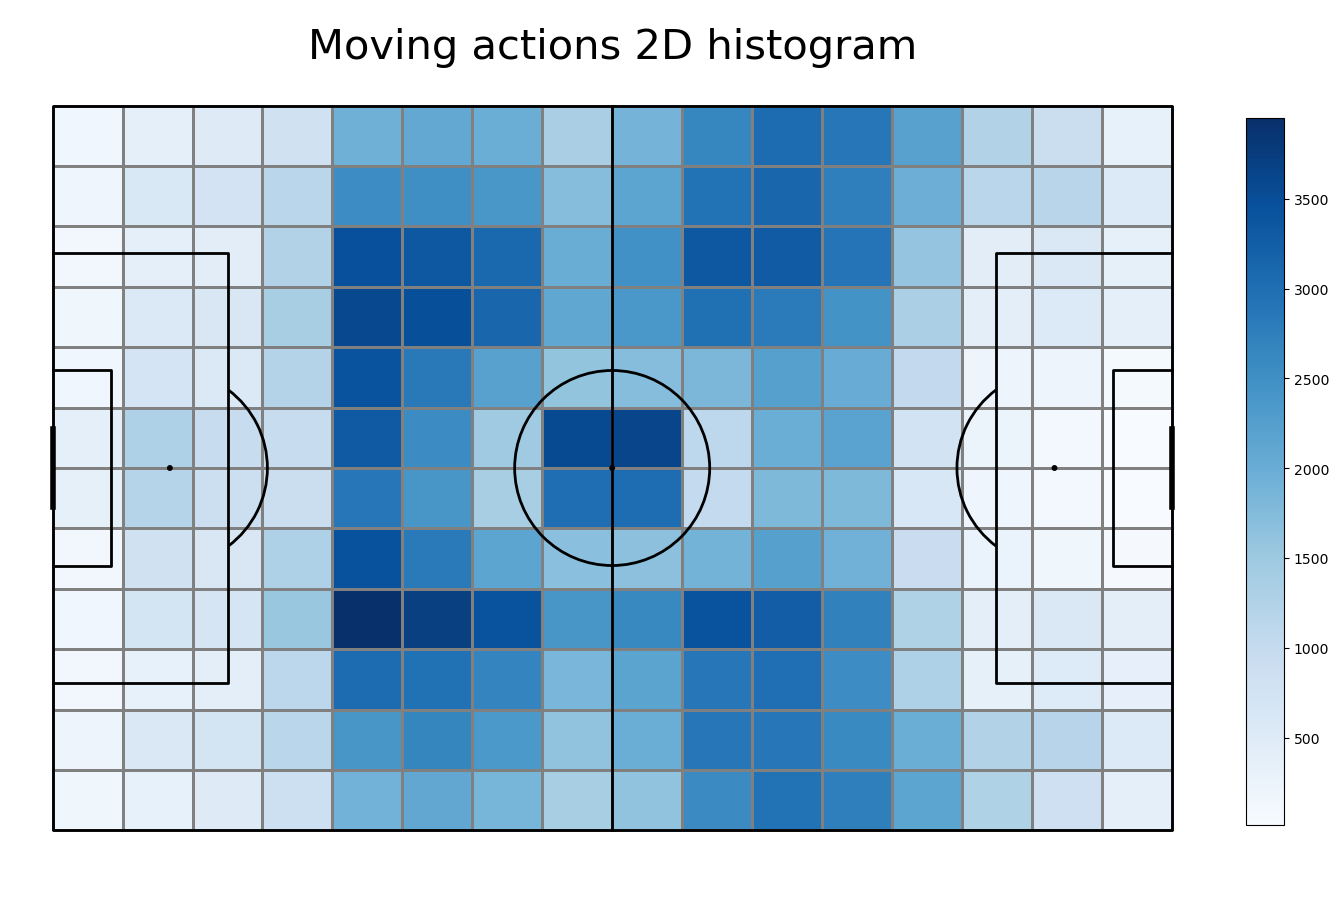

In [7]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

# Getting move data frame
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

# Filtering out of the field actions
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

# Extracting action coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

# Creating 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

# Plotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()

# Getting the array
move_count = move["statistic"]

### Shots

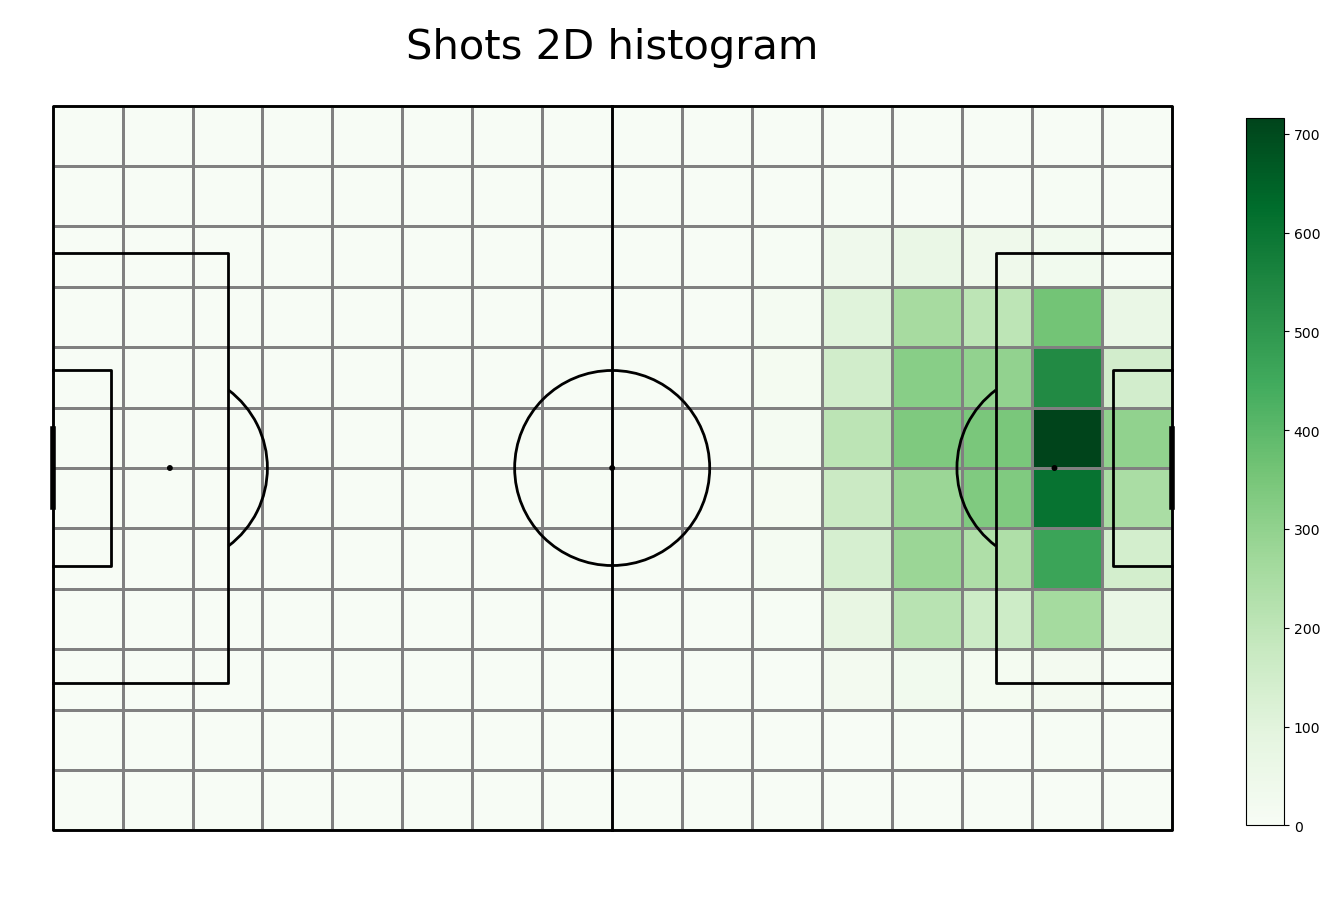

In [8]:
# Getting shot data frame
shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

# Creating 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

# Plotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

### Goals

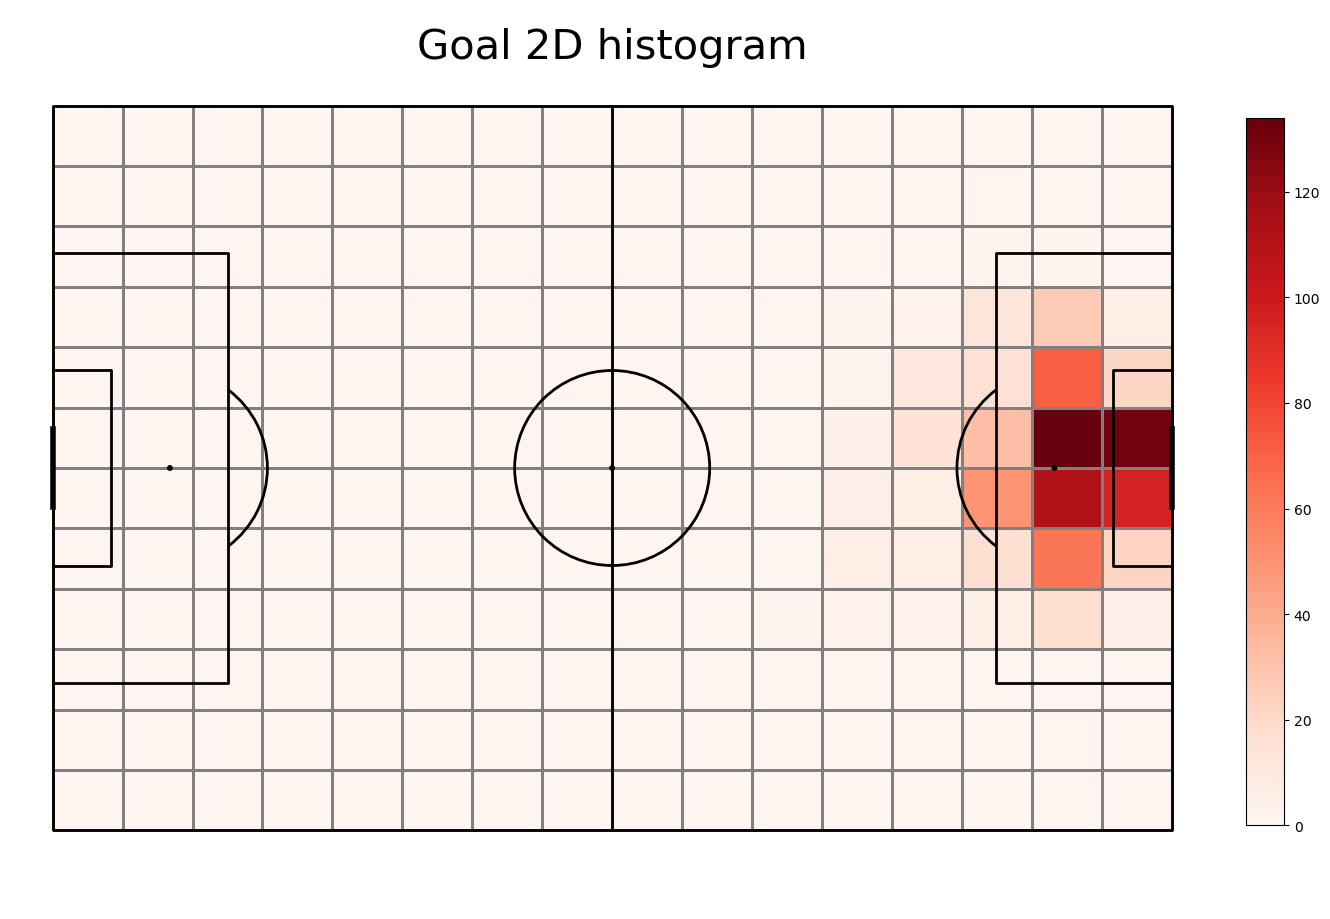

In [9]:
# Getting goal data frame
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

# Plotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

### Move probability

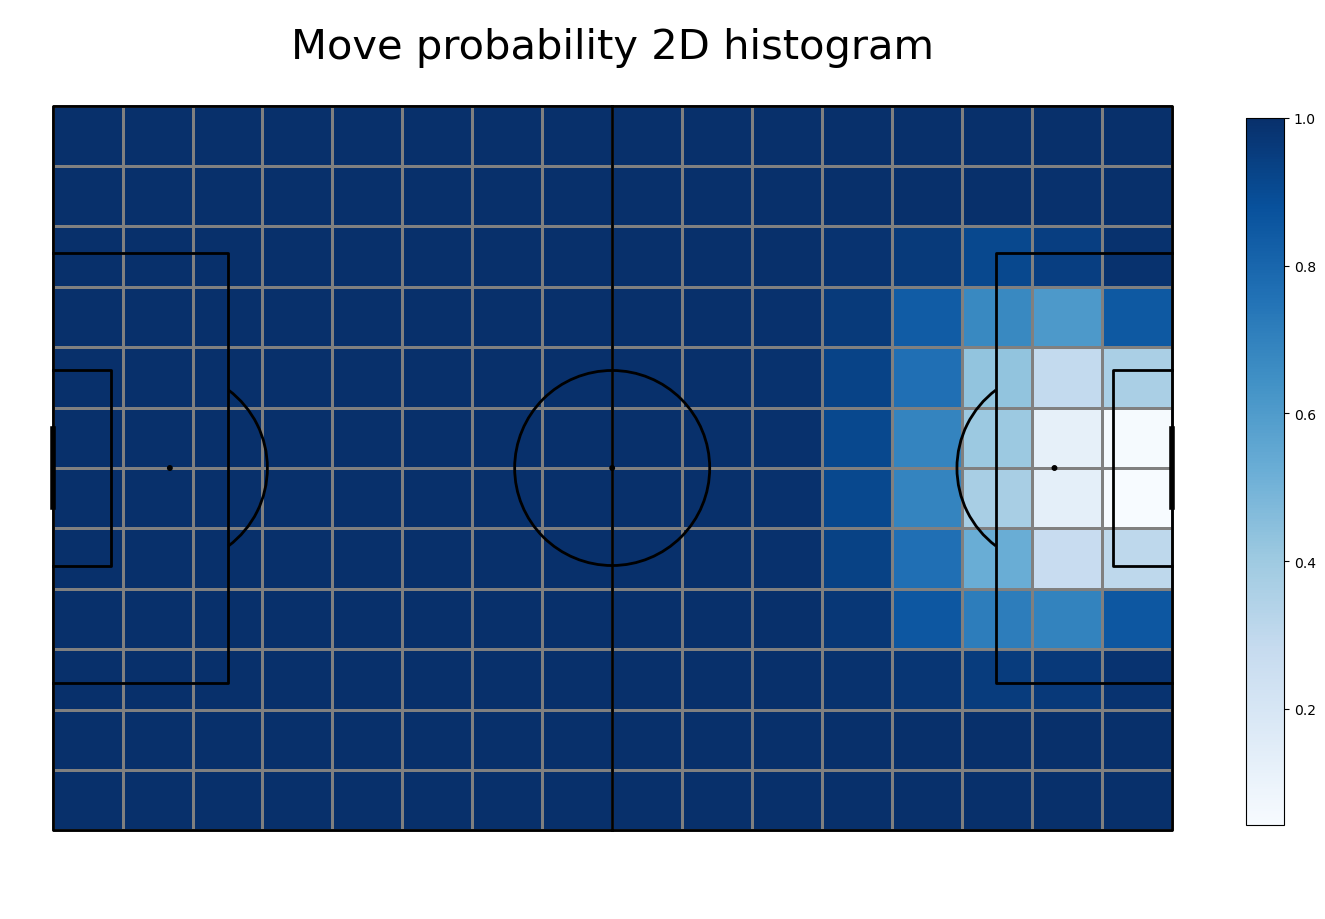

In [10]:
# Calculating move probability for each bin 
move_probability = move_count/(move_count+shot_count)

# PLotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

### Shot probability

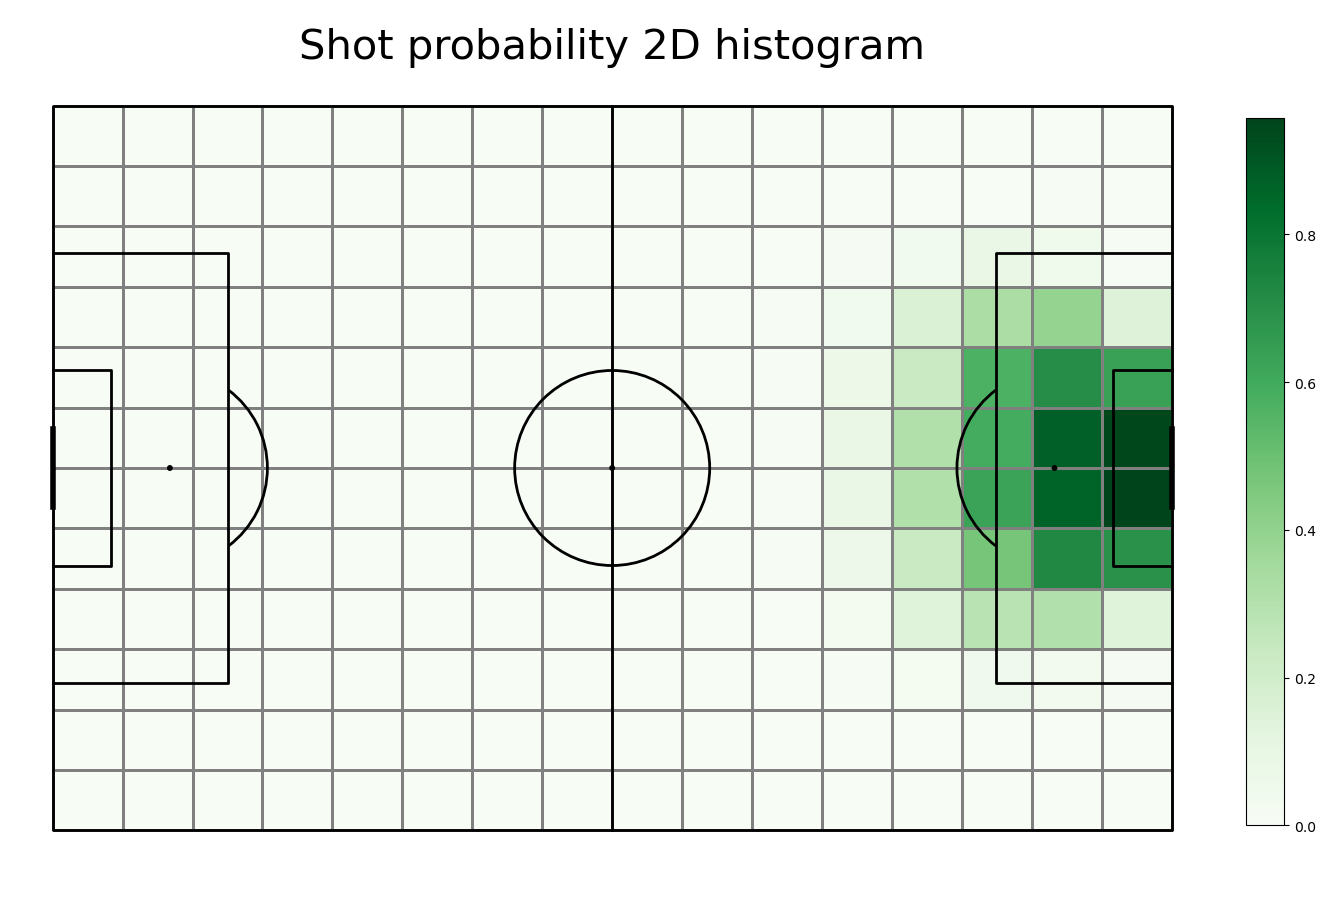

In [11]:
# Calculating shot probability for each bin 
shot_probability = shot_count/(move_count+shot_count)

# PLotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

### Goal probability

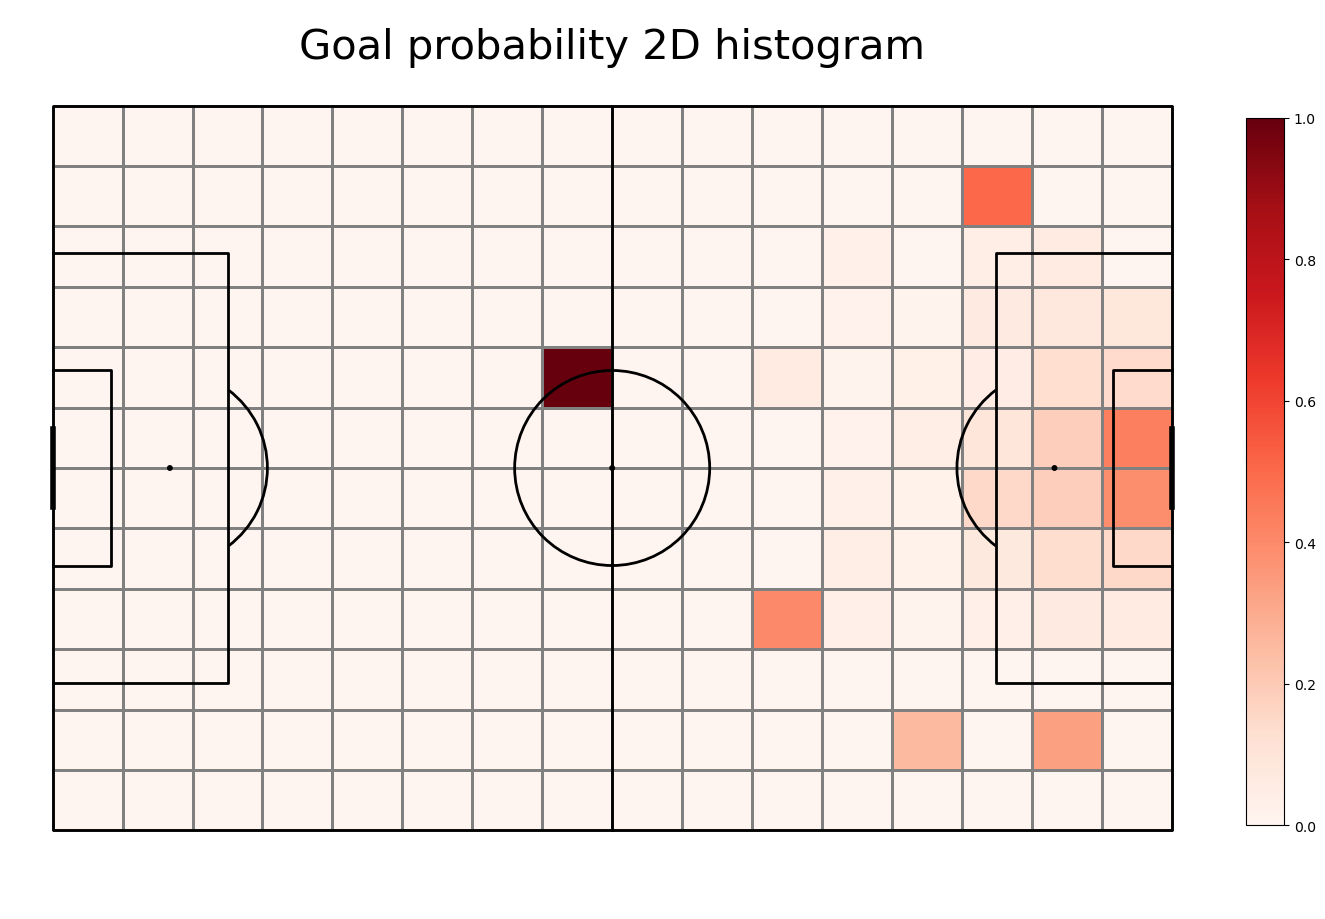

In [12]:
# Calculating shot probability for each bin 
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

# PLotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Legending the plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

### Transition matrices

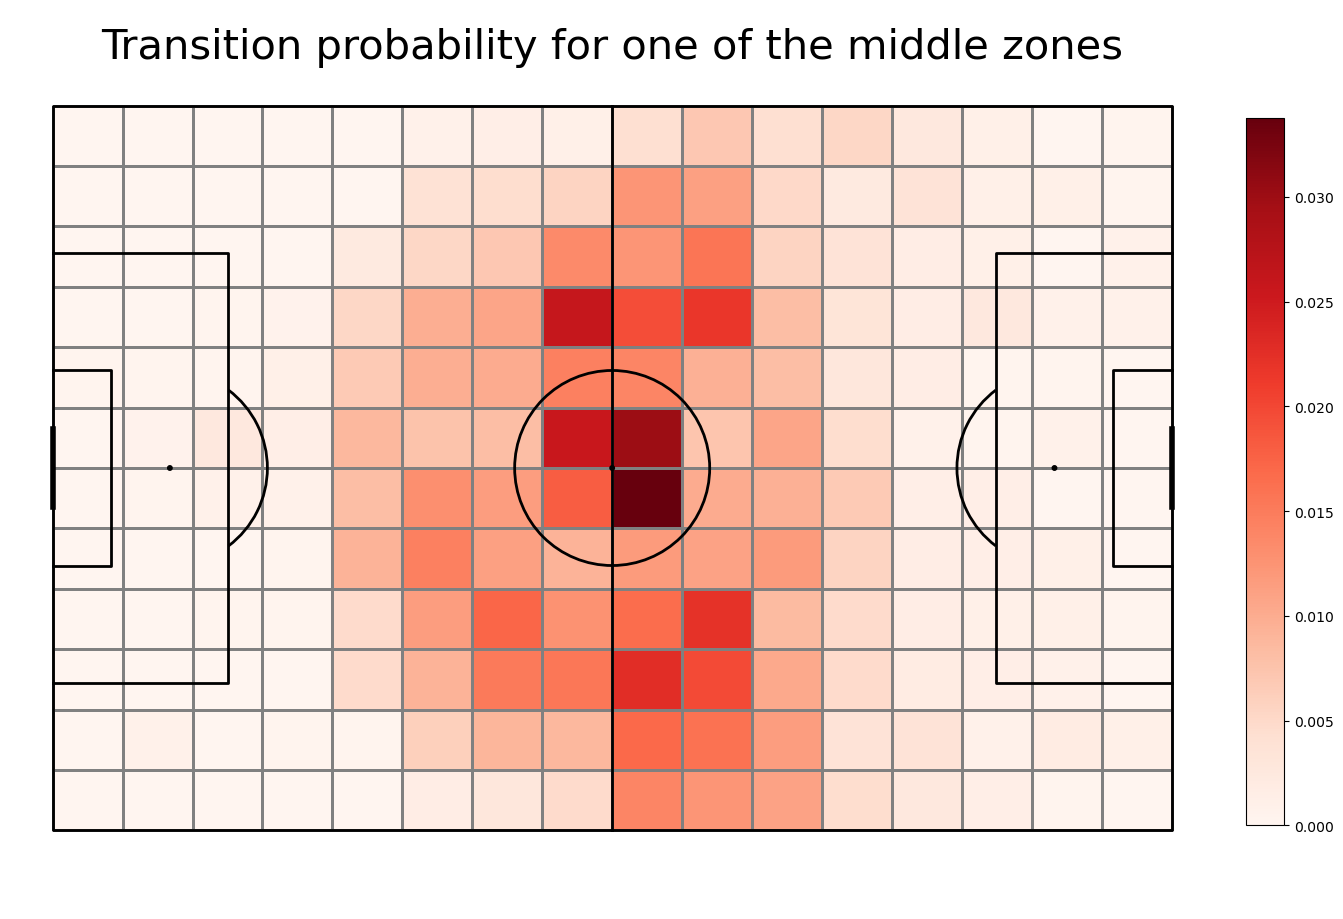

In [13]:
# Getting move starting indexes
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
# Getting move ending indexes
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

# Building a data frame with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    # Getting all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

# Plotting data
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Changing the index here to change the zone.
goal["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

# Legending the plot 
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

### Calculating Expected Threat matrix

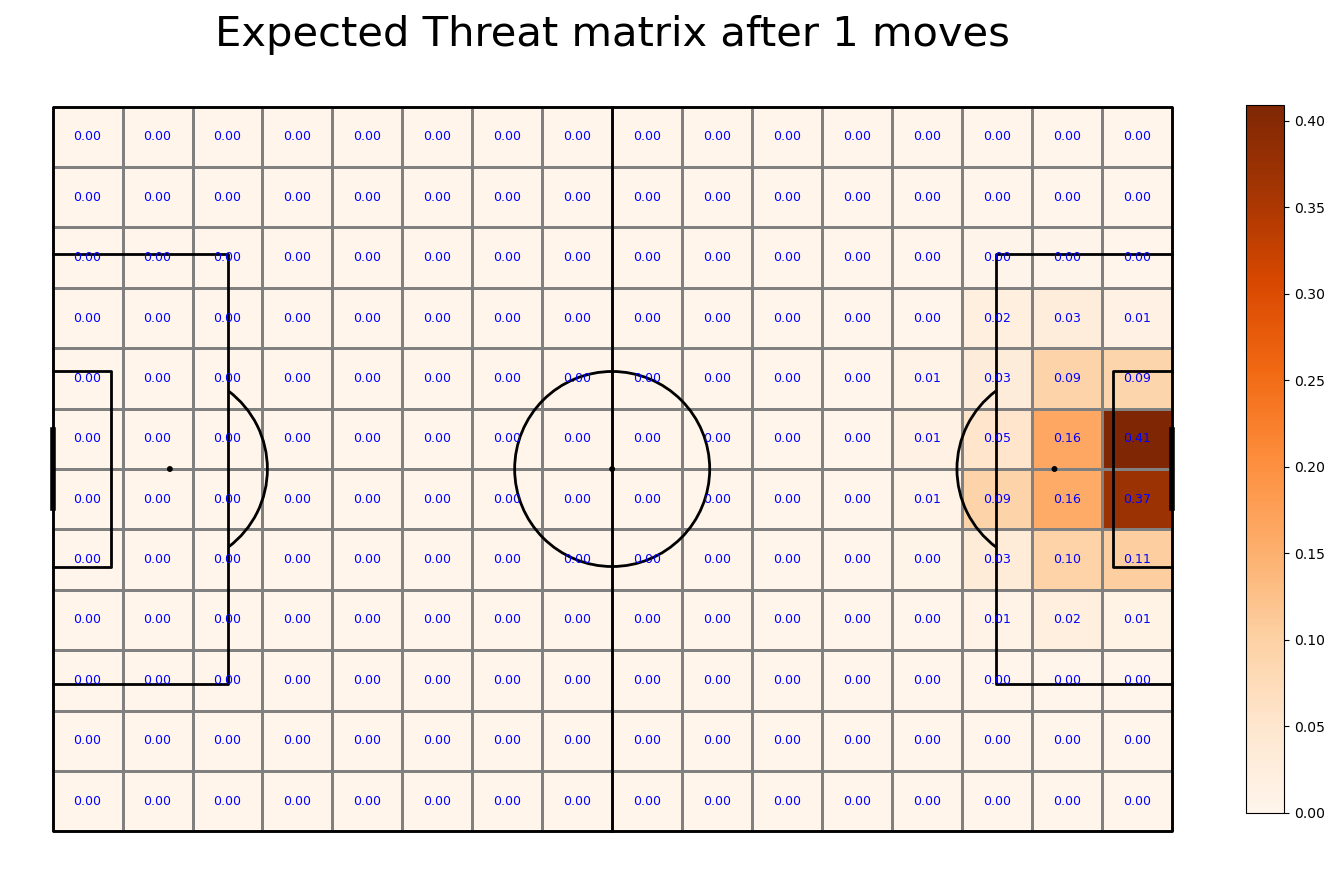

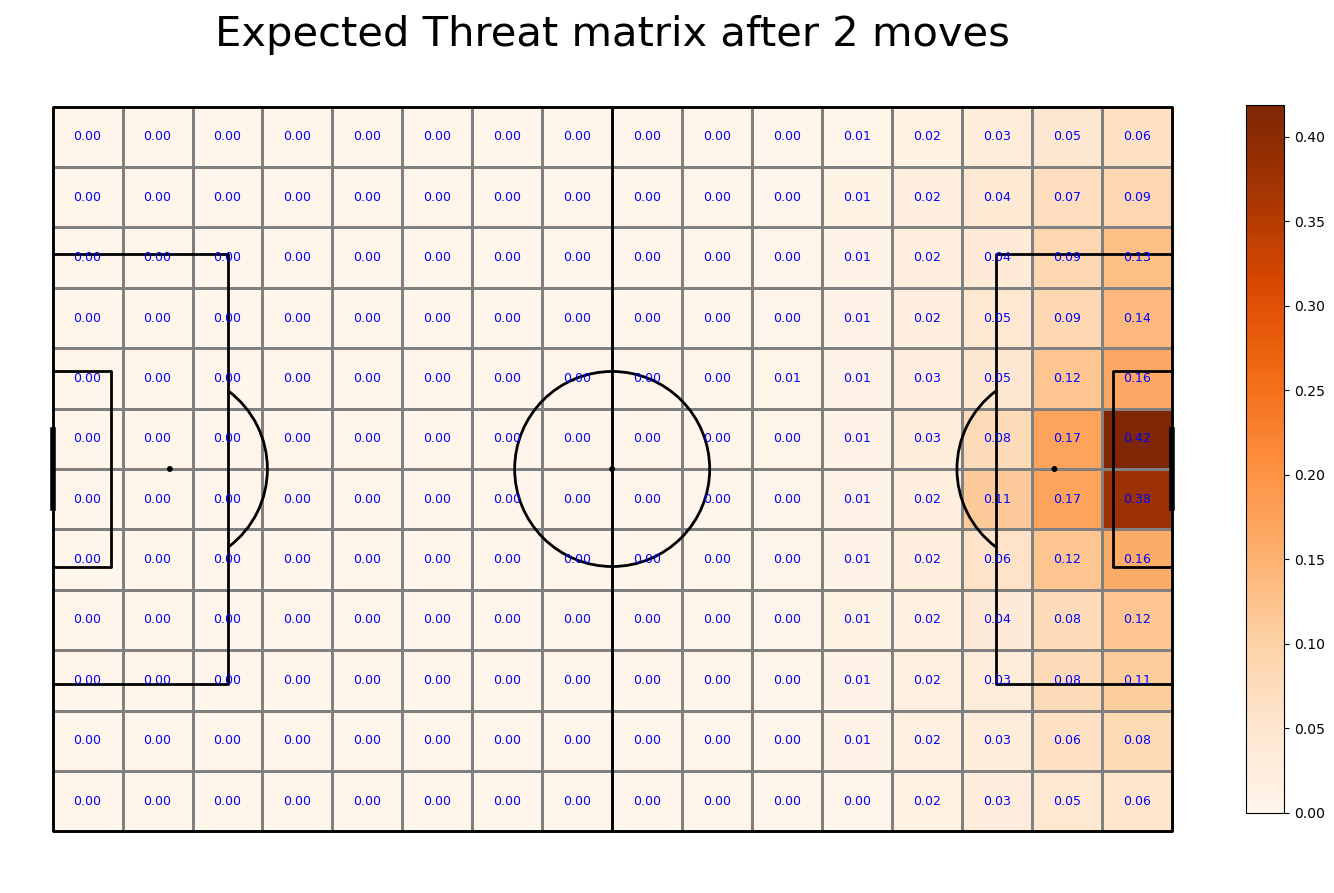

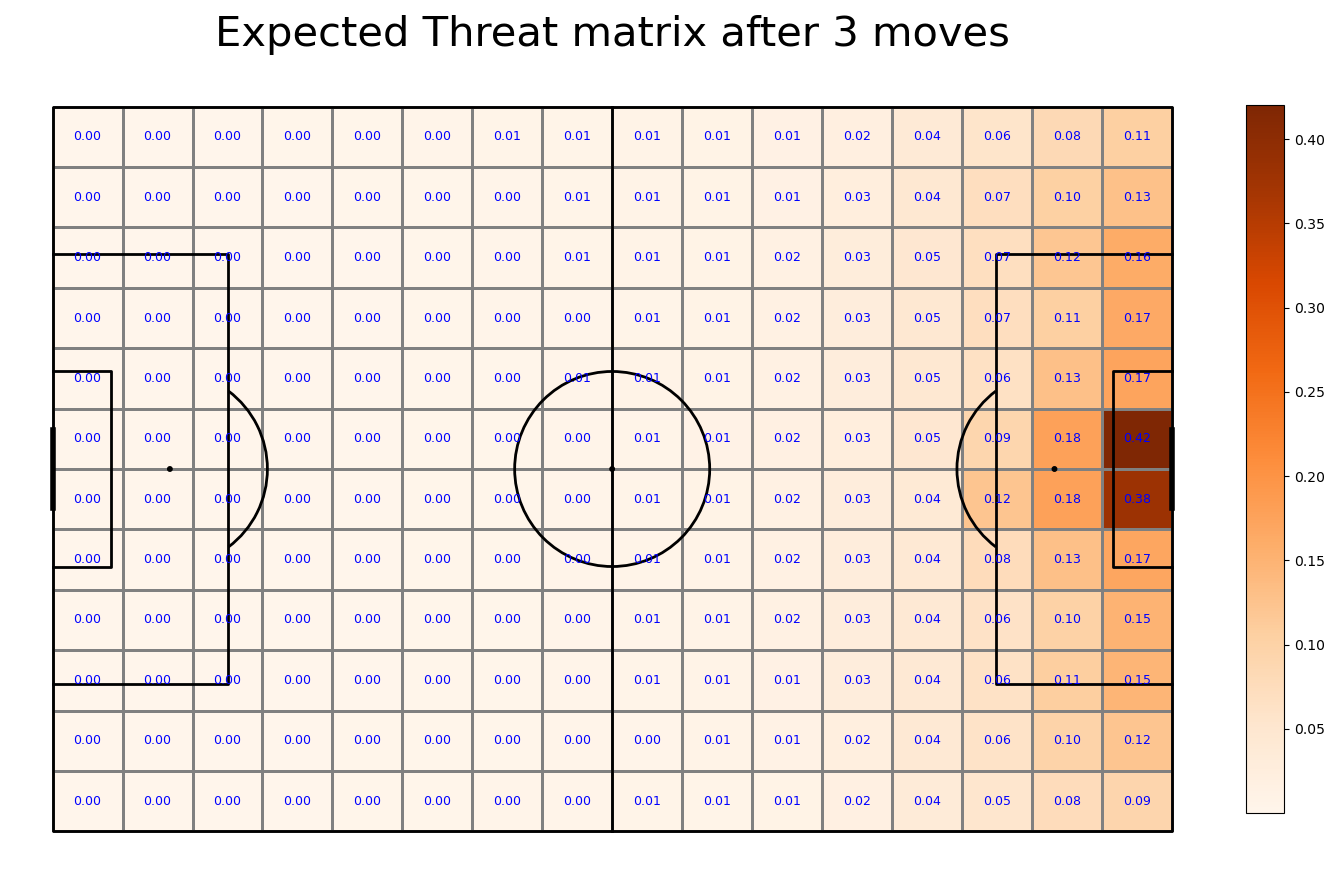

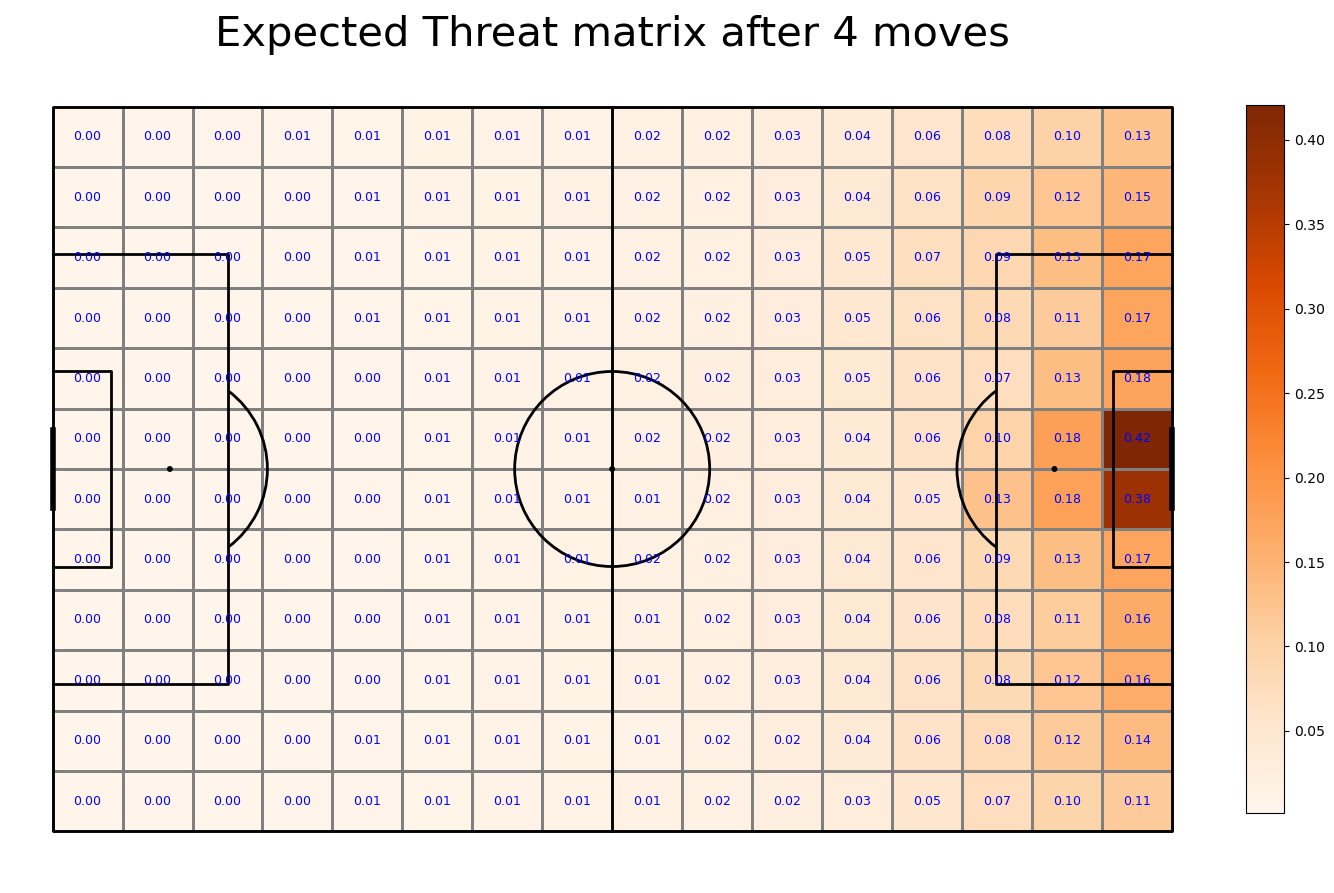

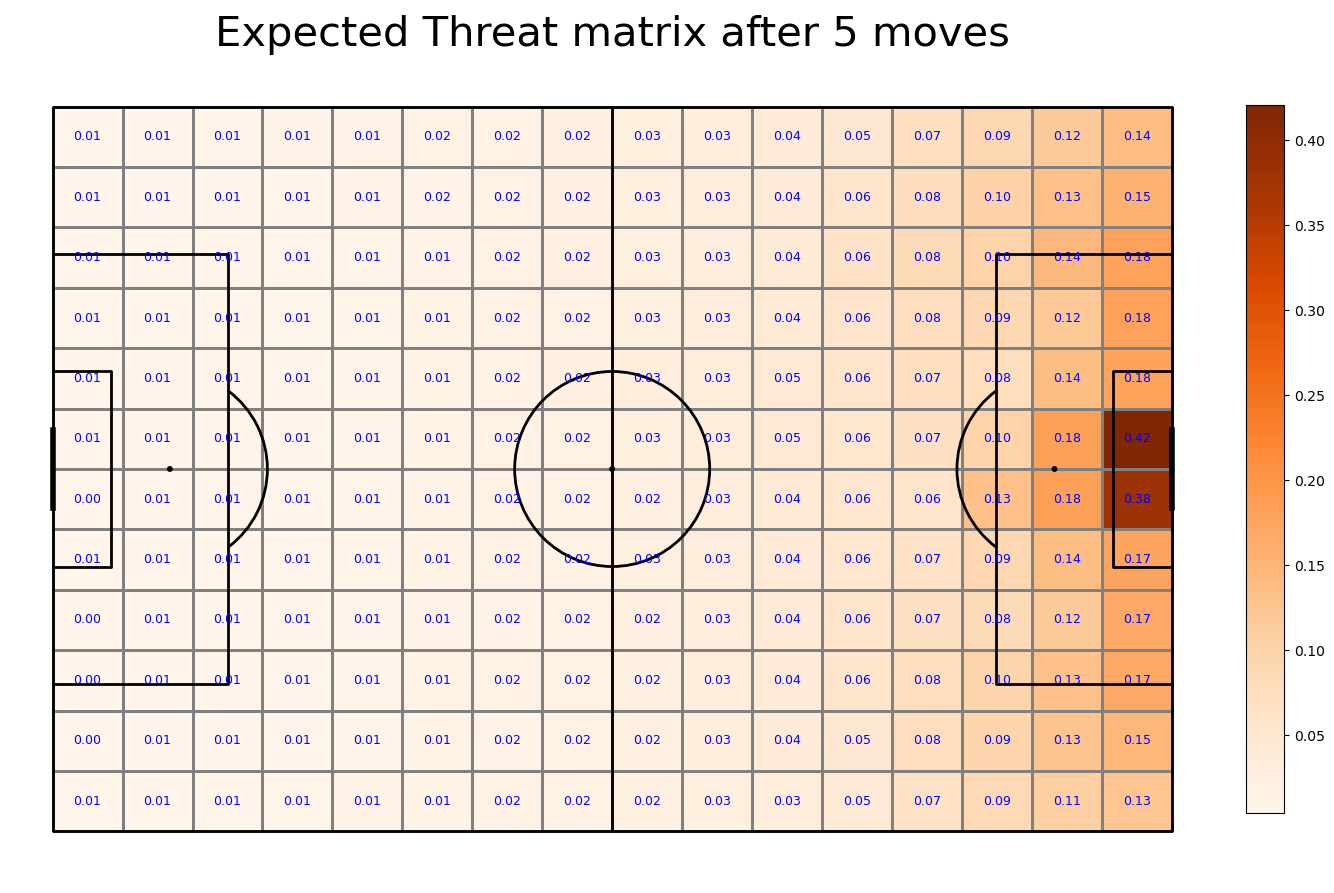

In [14]:
# Stocking data into an array
transition_matrices_array = np.array(transition_matrices)

# Initializing xT matrix
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    # Plotting data
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    
    # Legending the plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

### Applying xT value to moving actions

In [15]:
# Keeping only successful moves
successful_moves = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

# Calculating xT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)
# Storing results
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

### Finding out players with highest xT

In [16]:
# Grouping by player
xT_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

# Merging player name
path = r"D:\WyScoutOpenData\players.json"
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

# Printing summary
summary = xT_by_player.merge(to_merge, how = "left", on = ["playerId"])

# Getting minutes played by player
path = r"D:\WyScoutOpenData\minutes_played\minutes_played_per_game_England.json"
with open(path) as f:
    minutes_per_game = json.load(f)

# Filtering over 400 minutes
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

# Calculating per 90
summary["xT_per_90"] = summary["xT_added"] * 90 / summary["minutesPlayed"]

# Adjusting for possession
path = r"D:\WyScoutOpenData\player_possessions\player_possession_England.json"
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)

# Merging it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
27,Fàbregas,1.954186
271,K. De Bruyne,1.546140
68,P. Pogba,1.517259
22,M. Özil,1.511402
78,J. Shelvey,1.453346


## Possession chains

### Opening data

In [17]:
# Loading and storing data into train data frame
path = r"D:\WyScoutOpenData\events\events_England.json"
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
df = df.reset_index()

### Preparing data

In [18]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

# Getting interruptions
interruption = df.loc[df["eventName"] == "Interruption"]

# Filtering out non-accurate duels (in WyScout duels are saved twice, for both team)
lost_duels = df.loc[df["eventName"] == "Duel"]
lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
df = df.drop(lost_duels.index)

# Filtering ball out of the field - I can get this anyways
out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)

# Filtering save attempts
goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalies.index)

### Isolating possession chain

In [19]:
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    #potential +0s
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possesion_chain"] = 0
    df["possesion_chain_team"] = 0

    for i, row in df.iterrows():
        #add value
        df.at[i, "possesion_chain"] = chain
        df.at[i, "possesion_chain_team"] = chain_team
        # if pass not accurate/lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                    stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                    stop_criterion += 1
        #if ball intercepted properly add 2
        if row["eventName"] == "Others on the ball":
               if row["teamId"] == row["nextTeamId"]:
                   stop_criterion += 2
        #if shot, add 2 to stop criteriom
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
                stop_criterion += 2
        #if ball out of field, add 2
        if row["kickedOut"] == 1:
                stop_criterion += 2
        #criterion for stopping when half ended
        if row["matchPeriod"] != period:
                chain += 1
                stop_criterion = 0
                chain_team = row['teamId']
                period = row["matchPeriod"]
                df.at[i, "possesion_chain"] = chain
                df.at[i, "possesion_chain_team"] = chain_team
        #possesion chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']
    return df

In [20]:
# Testing the previous function
df = isolateChains(df)
df.loc[df["possesion_chain"] == 4][["eventName", "possesion_chain"]]

,eventName,possesion_chain
36,Free Kick,4
37,Pass,4
38,Duel,4
40,Duel,4
42,Pass,4
43,Pass,4
44,Pass,4
45,Pass,4
46,Shot,4


### Calculating xG value

In [21]:
def calulatexG(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with xG for each shot

    """
    #very basic xG model based on
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers,
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers,
                               family=sm.families.Binomial()).fit()
    #assigning xG
    df["xG"] = 0
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]
    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    penalties = df.loc[df["subEventName"] == "Penalty"]
    #treating penalties like shots
    penalties["X"] = 11
    #calculate distance and angle
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 /(11**2 - (7.32/2)**2))
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    penalties = penalties.assign(xG = xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]
    return df

In [22]:
# Testing the previous function
df = calulatexG(df)
df.loc[df["possesion_chain"].isin([3,4])][["eventName", "possesion_chain", "xG"]]

,eventName,possesion_chain,xG
25,Pass,3,0.000000
26,Pass,3,0.000000
27,Duel,3,0.000000
30,Duel,3,0.000000
31,Duel,3,0.000000
34,Duel,3,0.000000
35,Foul,3,0.000000
36,Free Kick,4,0.000000
37,Pass,4,0.000000
38,Duel,4,0.000000


### Finding chains that ended with shot

In [23]:
def prepareChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with assigned values for chains

    """
    df["shot_end"] = 0
    #get number of chains
    no_chains = max(df["possesion_chain"].unique())
    indicies = []
    for i in range(no_chains+1):
        #all events get possesion chain
        possesion_chain_df = df.loc[df["possesion_chain"] == i]
        #check if the possesion chain is not empty
        if len(possesion_chain_df) > 0:
            #if ended with shot
            if possesion_chain_df.iloc[-1]["eventName"] == "Shot":
                #assign values
                df.loc[df["possesion_chain"] == i, "shot_end"] = 1
                xG = possesion_chain_df.iloc[-1]["xG"]
                df.loc[df["possesion_chain"] == i, "xG"] = xG
                #check if the previous ones did not end with foul
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df["possesion_chain"] == k]
                        #create a loop if e.g. 2 chains before and 1 chain before didn;t end with shot
                        while prev.iloc[-1]["eventName"] == "Foul":
                            #assign value for them
                            df.loc[df["possesion_chain"] == k, "xG"] = xG
                            df.loc[df["possesion_chain"] == k, "shot_end"] = 1
                            k = k-1
                            prev = df.loc[df["possesion_chain"] == k]
                    except:
                        k = k-1
            #get indiices of events made by possesion team
            team_indicies = possesion_chain_df.loc[possesion_chain_df["teamId"] == possesion_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)

    df = df.loc[indicies]
    return df

In [24]:
# Testing the previous function
df = prepareChains(df)
df.loc[df["possesion_chain"].isin([3,4])][["eventName", "possesion_chain", "xG"]]

,eventName,possesion_chain,xG
25,Pass,3,0.137573
26,Pass,3,0.137573
30,Duel,3,0.137573
31,Duel,3,0.137573
34,Duel,3,0.137573
36,Free Kick,4,0.137573
37,Pass,4,0.137573
38,Duel,4,0.137573
40,Duel,4,0.137573
42,Pass,4,0.137573


### Preparing data for modeling

In [25]:
# Filtering out dodgy
df = df.loc[df.apply(lambda x: len(x.positions) == 2, axis = 1)]

# Getting columns with coordinates and applying them transformations
df["x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
df["c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
df["x1"] = df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
df["c1"] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)

# Assigning (105, 0) to end of the shot
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0

# Preparing the plot
df["y0"] = df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
df["y1"] = df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
df.loc[df["eventName"] == "Shot", "y1"] = 34

### Possession chain that ended with a shot

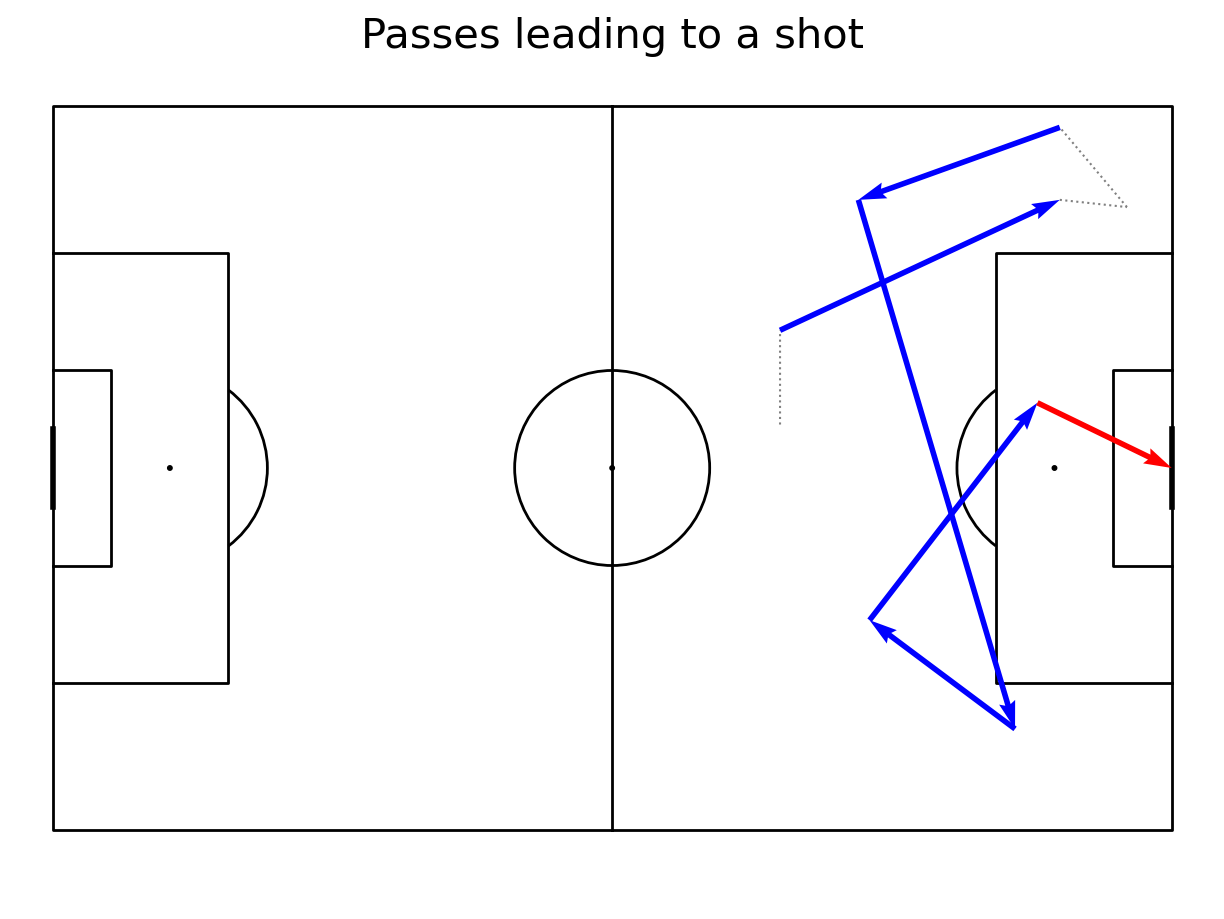

In [26]:
# Getting a chain
chain = df.loc[df["possesion_chain"] == 4]

# Getting passes
passes = chain.loc[chain["eventName"].isin(["Pass"])]

# Getting events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]

# Getting the shot (which is the last event of the chain)
shot = chain.iloc[-1]

# Plotting data
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#passes
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, color = "red", ax=ax['pitch'], zorder =  3)

#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

### Possession chain that did not end with a shot

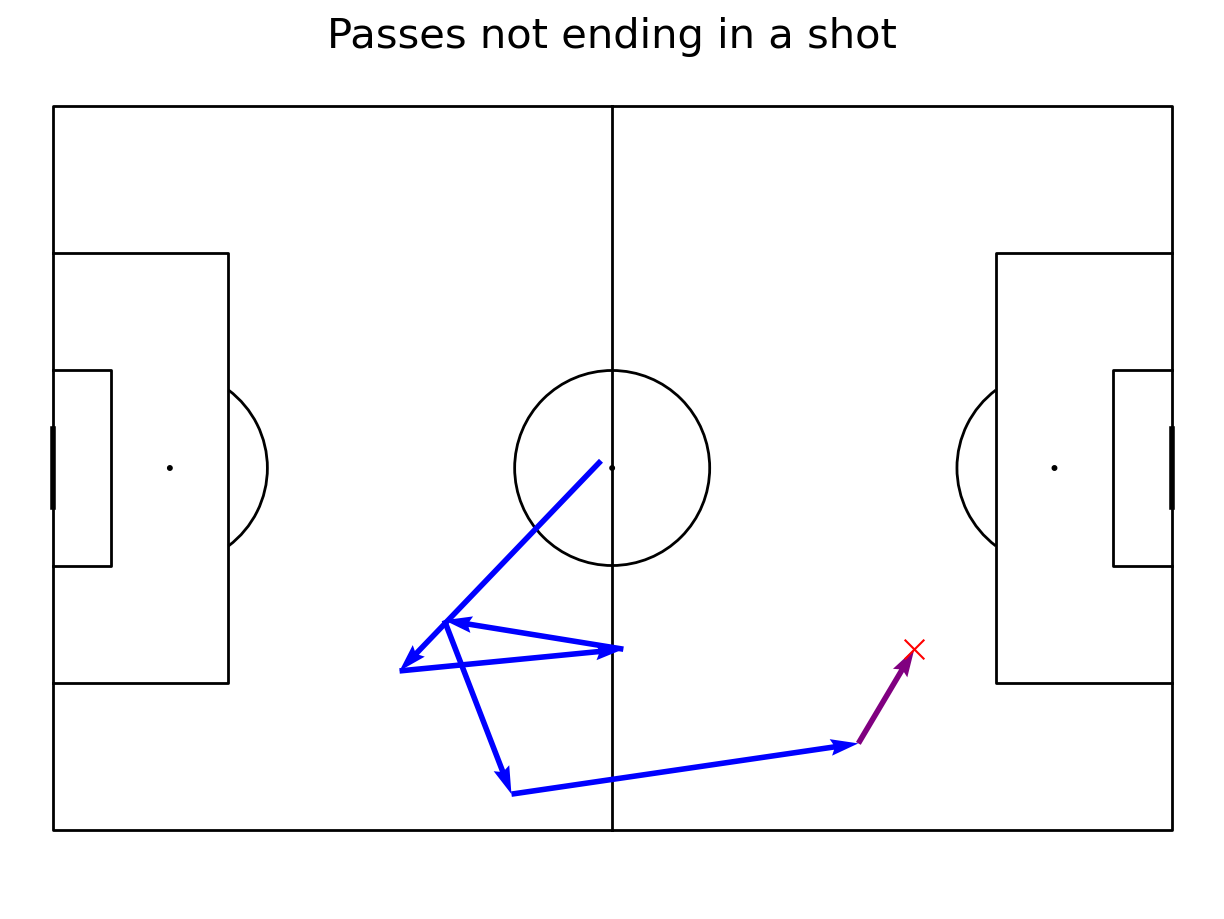

In [27]:
chain = df.loc[df["possesion_chain"] == 0]
passes = chain.loc[chain["eventName"].isin(["Pass", "Free Kick"])].iloc[:-1]
not_pass = chain.loc[(chain["eventName"] != "Pass") & (chain["eventName"] != "Free Kick")].iloc[:-1]
bad_pass = chain.iloc[-1]

pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
pitch.arrows(bad_pass.x0, bad_pass.y0,
            bad_pass.x1, bad_pass.y1, color = "purple", ax=ax['pitch'], zorder =  3)
pitch.scatter(bad_pass.x1, bad_pass.y1, marker = 'x', color = "red", ax=ax['pitch'], zorder =  3, s= 200)
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes not ending in a shot', ha='center', va='center', fontsize=30)
plt.show()

## Calculating xT (action-based)

### Opening the dataset

In [28]:
df = pd.DataFrame()
folder = r"D:\WyScoutOpenData\possession_chains"
for i in range(11):
    file_name = 'possession_chains_England' + str(i+1) + '.json'
    path = os.path.join(folder, file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)
df = df.reset_index()

### Preparing variables for models

In [29]:
# Defining model variables
var = ["x0", "x1", "c0", "c1"]

# Getting variable combiantions
inputs = []
inputs.extend(combinations_with_replacement(var, 1))
inputs.extend(combinations_with_replacement(var, 2))
inputs.extend(combinations_with_replacement(var, 3))

# Making new columns
for i in inputs:
    if len(i) > 1: #columns length 1 already exist
        column = ''
        x = 1
        for c in i:
            # Adding column name to be x0x1c0 for example
            column += c
            
            # Multiplying values in column
            x = x*df[c]
            
        # Creating a new column in data frame
        df[column] = x
        
        # Adding column to model variables
        var.append(column)

# Displaying first rows
df[var[-3:]].head(5)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752
3,6239.903040,13371.220800,28652.616000
4,24195.542400,20431.791360,17253.512704


### Calculating action-based Expected Threat values for passes

In [30]:
# Training procedure
# passes = df.loc[ df["eventName"].isin(["Pass"])]
# X = passes[var].values
# y = passes["shot_end"].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
# xgb = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10, random_state=123)
# scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
# print(np.mean(scores), np.std(scores))
# vxgb.fit(X_train, y_train)
# print(xgb.score(X_train, y_train))
# y_pred = xgb.predict(X_test)
# print(xgb.score(X_test, y_test))
# bst.save_model('r"D:\WyScoutOpenData\possession_chains\finalized_model.sav")

# Predicting if ended with shot
passes = df.loc[df["eventName"].isin(["Pass"])]
X = passes[var].values
y = passes["shot_end"].values

# Defining path to load model
path_model = r"D:\WyScoutOpenData\possession_chains\finalized_model.sav"
model = load(path_model)
model = model.get_booster()

# Predicting probability of shot ended
dmat = xgb.DMatrix(X)
y_pred_proba = model.predict(dmat, ntree_limit=model.best_iteration)

passes["shot_prob"] = y_pred_proba
#OLS
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred

# Calculating xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

# Displaying first rows
passes[["xG_pred", "shot_prob", "xT"]].head(5)

[13:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



,xG_pred,shot_prob,xT
0,0.121099,0.030814,0.003732
1,0.108244,0.044407,0.004807
2,0.121571,0.046664,0.005673
3,0.118808,0.032004,0.003802
4,0.116028,0.052184,0.006055


### Making a plot of pass values

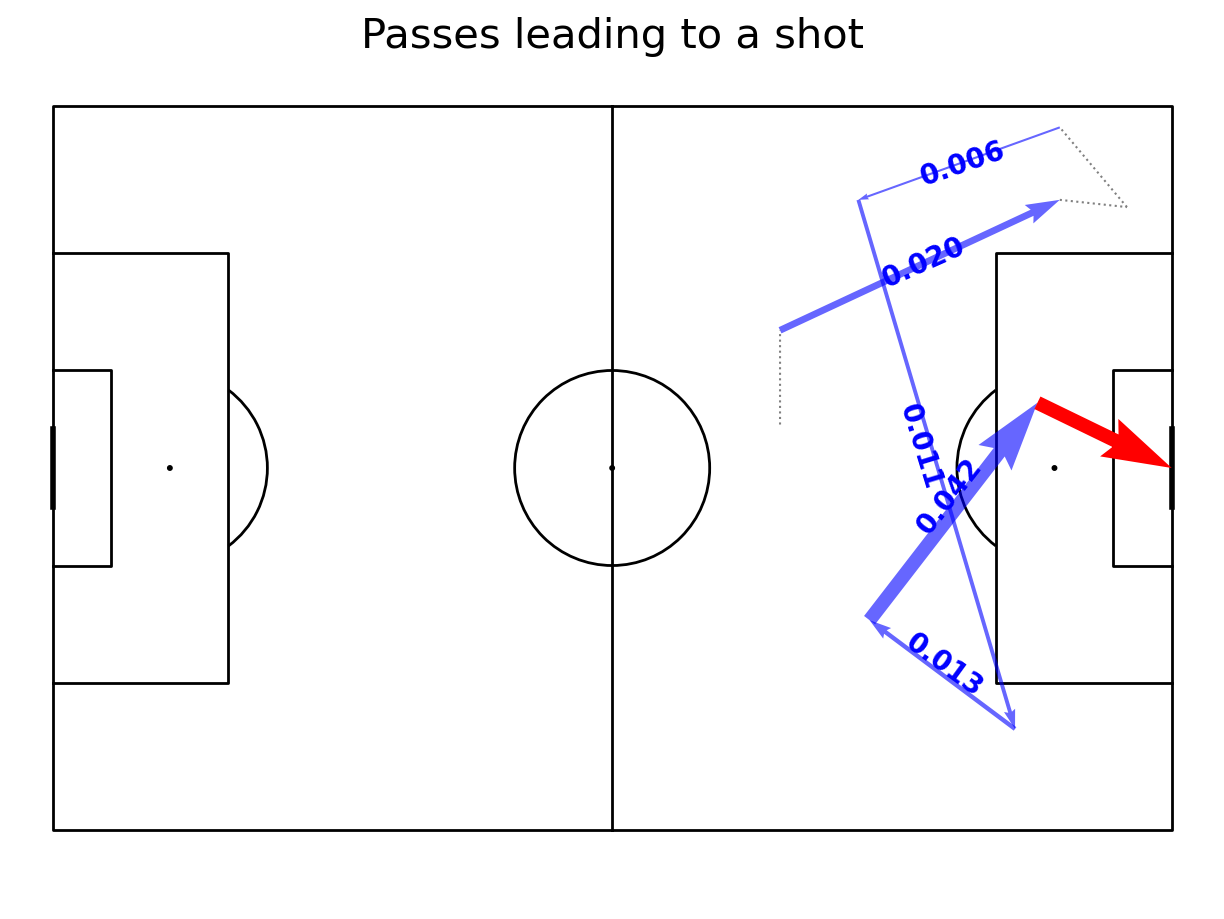

In [31]:
# Getting a chain
chain = df.loc[df["possesion_chain"] == 4]

# Getting passes
passes_in = passes.loc[df["possesion_chain"] == 4]
max_value = passes_in["xT"].max()

# Getting events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]

# Getting the shot (which is the last event of the chain)
shot = chain.iloc[-1]

# Plotting data
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Adding size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    
    # Adjusting the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    
    # Getting angle
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi
    
    # Plotting lines on the pitch
    pitch.arrows(row.x0, row.y0, row.x1, row.y1,
                        alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])
    
    # Annotating text
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)

#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

### Finding out players with highest action-based Expected Threat

In [32]:
# Grouping by player
summary = passes[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()

# Adding player name
path = r"D:\WyScoutOpenData\players.json"
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = summary.merge(to_merge, how = "left", on = ["playerId"])

# Getting minutes
path = r"D:\WyScoutOpenData\minutes_played\minutes_played_per_game_England.json"
with open(path) as f:
    minutes_per_game = json.load(f)

# Filtering over 400 minutes
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

# Calculating per 90
summary["xT_p90"] = summary["xT"] * 90 / summary["minutesPlayed"]

# Adjusting for possesion
path = r"D:\WyScoutOpenData\player_possessions\player_possession_England.json"
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)

# Merging it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

# Adjusting per possesion
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
22,M. Özil,1.550677
27,Fàbregas,1.460971
250,E. Hazard,1.408643
30,A. Sánchez,1.396073
117,David Silva,1.336769
